<a href="https://colab.research.google.com/github/INmais/reliable/blob/master/Reliable_2023_ICARO_Discomfort_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison ICARO with discomfort hours
# Clustering municipalities within the same health district
### Validation (nº of deaths) - needs distributed lag non linear model (as the relationship is "v" or "j" and lagged in time)


#Data
- ICARO (per main heath distric) source:
- CTT mp mapeamento cp7
- CENSOS (https://mapas.ine.pt/download/index2021.phtml)
- censosmunicipio['thermal profile'] = censosmunicipio['idxmax'].map(dictprofiles))

# References: 

Gasparrini A, Armstrong B, Kenward MG. Distributed lag non-linear models. Stat Med. 2010 Sep 20;29(21):2224-34. doi: 10.1002/sim.3940. PMID: 20812303; PMCID: PMC2998707.

Global, regional, and national burden of mortality associated with non-optimal ambient temperatures from 2000 to 2019: a three-stage modelling study https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(21)00081-4/fulltext


Mortality risk attributable to high and low ambient
temperature: a multicountry observational study https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(14)62114-0/fulltext

## Libraries

In [5]:
! pip install geopandas
! pip install scikit-learn
! pip install tslearn
! pip install requests
! pip install glob2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 65.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.8/875.8 KB 14.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## General

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob2
import os

In [4]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/',force_remount=True) 

Mounted at /content/drive/


In [6]:
#output
import os
os.chdir('/content/drive/Shareddrives/Reliable Project/Data/')  

### ICARO

In [7]:
import pandas as pd
icaro="/content/drive/Shareddrives/Reliable Project/Data/IndiceICARO.csv"
icaro= pd.read_csv(icaro, header=0, sep=";",infer_datetime_format=True, decimal=',') 

In [8]:
#import datetime
from datetime import datetime
icaro['Data'] = icaro['Data'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [9]:
icaro = icaro.set_index('Data')
icaro = icaro[['Norte','Centro','LVT','Alentejo','Algarve']]

In [10]:
icaro.Norte = pd.to_numeric(icaro.Norte, errors='coerce')
icaro.Centro = pd.to_numeric(icaro.Centro, errors='coerce')
icaro.LVT= pd.to_numeric(icaro.LVT, errors='coerce')
icaro.Alentejo = pd.to_numeric(icaro.Alentejo, errors='coerce')
icaro.Algarve = pd.to_numeric(icaro.Algarve, errors='coerce')

In [11]:
new_icaro_2013 = icaro.loc['01/05/2013':'30/09/2013']
new_icaro_2013 = new_icaro_2013.apply(pd.to_numeric, errors='coerce')

In [12]:
new_icaro_2018 = icaro.loc['01/05/2018':'30/09/2018']
new_icaro_2018 = new_icaro_2018.apply(pd.to_numeric, errors='coerce')

In [13]:
new_icaro_2013

,Norte,Centro,LVT,Alentejo,Algarve
Data,,,,,
2013-05-01,0.0,0.0,0.0,0.0,0.0
2013-05-02,0.0,0.0,0.0,0.0,0.0
2013-05-03,0.0,0.0,0.0,0.0,0.0
2013-05-04,0.0,0.0,0.0,0.0,0.0
2013-05-05,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2013-09-26,0.0,0.0,0.0,0.0,0.0
2013-09-27,0.0,0.0,0.0,0.0,0.0
2013-09-28,0.0,0.0,0.0,0.0,0.0


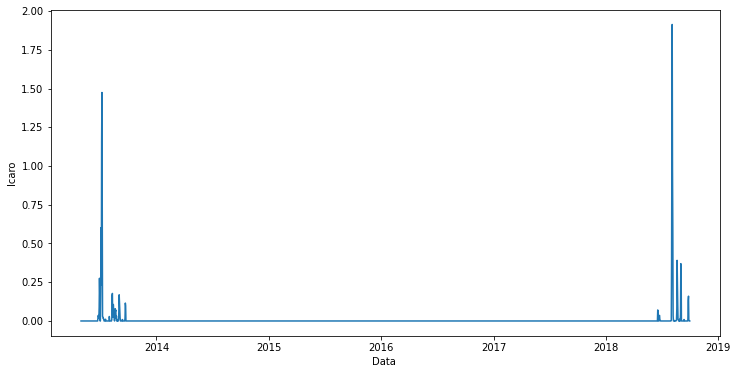

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(icaro['Norte'])
plt.xlabel('Data ')
plt.ylabel('Icaro')
plt.show()

### CTT

to match districts with municipalites

In [15]:
import pandas as pd
url_ctt="https://raw.githubusercontent.com/dssg-pt/mp-mapeamento-cp7/main/output_data/cod_post_freg_matched.csv"
ctt = pd.read_csv(url_ctt, header=0, sep=",") 

In [16]:
ctt

,CodigoPostal,Distrito,Concelho,Freguesia,Distrito_map,Concelho_map,Freguesia_map,Alteração RATF,Freguesia Final (Pós RATF)
0,3750011,Aveiro,Águeda,Agadão,Aveiro,Águeda,Agadão,Agregação,"União das freguesias de Belazaima do Chão, Cas..."
1,3750012,Aveiro,Águeda,Agadão,Aveiro,Águeda,Agadão,Agregação,"União das freguesias de Belazaima do Chão, Cas..."
2,3750013,Aveiro,Águeda,Agadão,Aveiro,Águeda,Agadão,Agregação,"União das freguesias de Belazaima do Chão, Cas..."
3,3750014,Aveiro,Águeda,Agadão,Aveiro,Águeda,Agadão,Agregação,"União das freguesias de Belazaima do Chão, Cas..."
4,3750015,Aveiro,Águeda,Agadão,Aveiro,Águeda,Agadão,Agregação,"União das freguesias de Belazaima do Chão, Cas..."
...,...,...,...,...,...,...,...,...,...
196188,3670263,Viseu,Vouzela,NaN,NaN,NaN,NaN,NaN,NaN
196189,3670264,Viseu,Vouzela,NaN,NaN,NaN,NaN,NaN,NaN
196190,3670265,Viseu,Vouzela,NaN,NaN,NaN,NaN,NaN,NaN
196191,3670262,Viseu,Vouzela,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
ctt = ctt.replace(to_replace ="Lagoa ",
                 value ="Lagoa")
ctt = ctt.replace(to_replace ="Meda",
                 value ="Mêda")

In [18]:
cttdic = dict(zip(ctt.Concelho, ctt.Distrito))

In [19]:
cttdic

{'Águeda': 'Aveiro',
 'Albergaria-a-Velha': 'Aveiro',
 'Anadia': 'Aveiro',
 'Arouca': 'Aveiro',
 'Aveiro': 'Aveiro',
 'Castelo de Paiva': 'Aveiro',
 'Espinho': 'Aveiro',
 'Estarreja': 'Aveiro',
 'Murtosa': 'Aveiro',
 'Ílhavo': 'Aveiro',
 'Mealhada': 'Aveiro',
 'Oliveira de Azeméis': 'Aveiro',
 'Oliveira do Bairro': 'Aveiro',
 'Ovar': 'Aveiro',
 'Santa Maria da Feira': 'Aveiro',
 'São João da Madeira': 'Aveiro',
 'Sever do Vouga': 'Aveiro',
 'Vagos': 'Aveiro',
 'Vale de Cambra': 'Aveiro',
 'Aljustrel': 'Beja',
 'Almodôvar': 'Beja',
 'Alvito': 'Beja',
 'Barrancos': 'Beja',
 'Beja': 'Beja',
 'Castro Verde': 'Beja',
 'Cuba': 'Beja',
 'Ferreira do Alentejo': 'Beja',
 'Mértola': 'Beja',
 'Moura': 'Beja',
 'Odemira': 'Beja',
 'Ourique': 'Beja',
 'Serpa': 'Beja',
 'Vidigueira': 'Beja',
 'Amares': 'Braga',
 'Barcelos': 'Braga',
 'Braga': 'Braga',
 'Cabeceiras de Basto': 'Braga',
 'Celorico de Basto': 'Braga',
 'Esposende': 'Braga',
 'Fafe': 'Braga',
 'Guimarães': 'Braga',
 'Vizela': 'Braga',
 '

In [20]:
dic_areas_saude =dict({'Aveiro': 'Região de Saúde do Norte',
'Beja': 'Região de Saúde do Alentejo',
'Braga': 'Região de Saúde do Norte',
'Bragança':'Região de Saúde do Norte',
'Castelo Branco': 'Região de Saúde do Centro',
'Coimbra': 'Região de Saúde do Centro',
'Évora': 'Região de Saúde do Alentejo',
'Faro': 'Região de Saúde do Algarve',
'Guarda': 'Região de Saúde do Centro',
'Leiria': 'Região de Saúde do Centro',
'Lisboa': 'Região de Saúde LVT',
'Portalegre': 'Região de Saúde do Alentejo',
'Porto': 'Região de Saúde do Norte',
'Santarém': 'Região de Saúde LVT',
'Setúbal': 'Região de Saúde LVT',
'Viana do Castelo': 'Região de Saúde do Norte',
'Vila Real': 'Região de Saúde do Norte',
'Viseu': 'Região de Saúde do Centro',
'Ilha da Madeira': 'Região de Saúde da Madeira',
'Ilha de Porto Santo': 'Região de Saúde da Madeira',
'Ilha de Santa Maria': 'Região de Saúde dos Açores', 
'Ilha de São Miguel': 'Região de Saúde dos Açores', 
'Ilha Terceira': 'Região de Saúde dos Açores', 
'Ilha da Graciosa': 'Região de Saúde dos Açores', 
'Ilha de São Jorge': 'Região de Saúde dos Açores', 
'Ilha do Pico': 'Região de Saúde dos Açores',
'Ilha do Faial': 'Região de Saúde dos Açores', 
'Ilha das Flores': 'Região de Saúde dos Açores', 
'Ilha do Corvo': 'Região de Saúde dos Açores'
})


### Census 2011

In [21]:
url_censos="/content/drive/Shareddrives/Reliable Project/Data/portugal2011.zip (Unzipped Files)/BGRI11_PT.csv"
censos = pd.read_csv(url_censos, header=0, sep=";", encoding = "ISO-8859-1") 

In [22]:
censord = censos[['ANO','GEO_COD','GEO_COD_DSG','NIVEL','NIVEL_DSG','N_EDIFICIOS_CONSTR_ANTES_1919','N_EDIFICIOS_CONSTR_1919A1945','N_EDIFICIOS_CONSTR_1946A1960','N_EDIFICIOS_CONSTR_1961A1970', 'N_EDIFICIOS_CONSTR_1971A1980','N_EDIFICIOS_CONSTR_1981A1990','N_EDIFICIOS_CONSTR_1991A1995', 'N_EDIFICIOS_CONSTR_1996A2000', 'N_EDIFICIOS_CONSTR_2001A2005','N_EDIFICIOS_CONSTR_2006A2011', 
'N_INDIVIDUOS_RESIDENT_0A4', 'N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_15A19','N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64','N_INDIVIDUOS_RESIDENT_65']]

In [23]:
censord['all buildings'] = censord['N_EDIFICIOS_CONSTR_ANTES_1919'] + censord['N_EDIFICIOS_CONSTR_1919A1945'] + censord['N_EDIFICIOS_CONSTR_1946A1960'] + censord['N_EDIFICIOS_CONSTR_1961A1970'] + censord['N_EDIFICIOS_CONSTR_1971A1980']+ censord['N_EDIFICIOS_CONSTR_1981A1990'] + censord['N_EDIFICIOS_CONSTR_1991A1995'] + censord['N_EDIFICIOS_CONSTR_1996A2000'] + censord['N_EDIFICIOS_CONSTR_2001A2005'] + censord['N_EDIFICIOS_CONSTR_2006A2011']

<ipython-input-23-2940aa1b4bf5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censord['all buildings'] = censord['N_EDIFICIOS_CONSTR_ANTES_1919'] + censord['N_EDIFICIOS_CONSTR_1919A1945'] + censord['N_EDIFICIOS_CONSTR_1946A1960'] + censord['N_EDIFICIOS_CONSTR_1961A1970'] + censord['N_EDIFICIOS_CONSTR_1971A1980']+ censord['N_EDIFICIOS_CONSTR_1981A1990'] + censord['N_EDIFICIOS_CONSTR_1991A1995'] + censord['N_EDIFICIOS_CONSTR_1996A2000'] + censord['N_EDIFICIOS_CONSTR_2001A2005'] + censord['N_EDIFICIOS_CONSTR_2006A2011']


In [24]:
censord['all pop'] = censord['N_INDIVIDUOS_RESIDENT_0A4'] + censord['N_INDIVIDUOS_RESIDENT_5A9'] + censord['N_INDIVIDUOS_RESIDENT_10A13'] + censord['N_INDIVIDUOS_RESIDENT_14A19'] + censord['N_INDIVIDUOS_RESIDENT_15A19'] + censord['N_INDIVIDUOS_RESIDENT_20A24'] + censord['N_INDIVIDUOS_RESIDENT_20A64'] + censord['N_INDIVIDUOS_RESIDENT_25A64'] + censord['N_INDIVIDUOS_RESIDENT_65']

<ipython-input-24-43fbecbb38ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censord['all pop'] = censord['N_INDIVIDUOS_RESIDENT_0A4'] + censord['N_INDIVIDUOS_RESIDENT_5A9'] + censord['N_INDIVIDUOS_RESIDENT_10A13'] + censord['N_INDIVIDUOS_RESIDENT_14A19'] + censord['N_INDIVIDUOS_RESIDENT_15A19'] + censord['N_INDIVIDUOS_RESIDENT_20A24'] + censord['N_INDIVIDUOS_RESIDENT_20A64'] + censord['N_INDIVIDUOS_RESIDENT_25A64'] + censord['N_INDIVIDUOS_RESIDENT_65']


In [25]:
censord['GEO_COD'] = censord['GEO_COD'].str.replace("\'", "")

<ipython-input-25-e7aea87181dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censord['GEO_COD'] = censord['GEO_COD'].str.replace("\'", "")


In [26]:
censosmunicipio = censord[censord['NIVEL'] == 5]  

In [27]:
censosmunicipio['Minimum'] = censosmunicipio.loc[:, ['N_EDIFICIOS_CONSTR_ANTES_1919', 'N_EDIFICIOS_CONSTR_1919A1945', 'N_EDIFICIOS_CONSTR_1946A1960', 'N_EDIFICIOS_CONSTR_1961A1970', 'N_EDIFICIOS_CONSTR_1971A1980', 'N_EDIFICIOS_CONSTR_1981A1990', 'N_EDIFICIOS_CONSTR_1991A1995', 'N_EDIFICIOS_CONSTR_1996A2000', 'N_EDIFICIOS_CONSTR_2001A2005', 'N_EDIFICIOS_CONSTR_2006A2011']].min(axis=1)
censosmunicipio['idxmax'] = censosmunicipio.loc[:, ['N_EDIFICIOS_CONSTR_ANTES_1919', 'N_EDIFICIOS_CONSTR_1919A1945', 'N_EDIFICIOS_CONSTR_1946A1960', 'N_EDIFICIOS_CONSTR_1961A1970', 'N_EDIFICIOS_CONSTR_1971A1980', 'N_EDIFICIOS_CONSTR_1981A1990', 'N_EDIFICIOS_CONSTR_1991A1995', 'N_EDIFICIOS_CONSTR_1996A2000', 'N_EDIFICIOS_CONSTR_2001A2005', 'N_EDIFICIOS_CONSTR_2006A2011']].idxmax(axis=1)
censosmunicipio['idxmin'] = censosmunicipio.loc[:, ['N_EDIFICIOS_CONSTR_ANTES_1919', 'N_EDIFICIOS_CONSTR_1919A1945', 'N_EDIFICIOS_CONSTR_1946A1960', 'N_EDIFICIOS_CONSTR_1961A1970', 'N_EDIFICIOS_CONSTR_1971A1980', 'N_EDIFICIOS_CONSTR_1981A1990', 'N_EDIFICIOS_CONSTR_1991A1995', 'N_EDIFICIOS_CONSTR_1996A2000', 'N_EDIFICIOS_CONSTR_2001A2005', 'N_EDIFICIOS_CONSTR_2006A2011']].idxmin(axis=1)

<ipython-input-27-ecdad5fbf861>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censosmunicipio['Minimum'] = censosmunicipio.loc[:, ['N_EDIFICIOS_CONSTR_ANTES_1919', 'N_EDIFICIOS_CONSTR_1919A1945', 'N_EDIFICIOS_CONSTR_1946A1960', 'N_EDIFICIOS_CONSTR_1961A1970', 'N_EDIFICIOS_CONSTR_1971A1980', 'N_EDIFICIOS_CONSTR_1981A1990', 'N_EDIFICIOS_CONSTR_1991A1995', 'N_EDIFICIOS_CONSTR_1996A2000', 'N_EDIFICIOS_CONSTR_2001A2005', 'N_EDIFICIOS_CONSTR_2006A2011']].min(axis=1)
<ipython-input-27-ecdad5fbf861>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [28]:
#Dictionary
data = {
        'Censos_ID': ['N_EDIFICIOS_CONSTR_ANTES_1919',
                  'N_EDIFICIOS_CONSTR_1919A1945',
                  'N_EDIFICIOS_CONSTR_1946A1960',
                  'N_EDIFICIOS_CONSTR_1961A1970', 
                  'N_EDIFICIOS_CONSTR_1971A1980',
                  'N_EDIFICIOS_CONSTR_1981A1990',
                  'N_EDIFICIOS_CONSTR_1991A1995', 
                  'N_EDIFICIOS_CONSTR_1996A2000', 
                  'N_EDIFICIOS_CONSTR_2001A2005',
                  'N_EDIFICIOS_CONSTR_2006A2011'],
        'sim':  ['before 1918', '1919-1945', '1946-1960','1961-1970', '1971-1980', '1981-1990', '1991-1995','1996-2000', '2001-2005', '2006-2011']
        }

dictprofiles = pd.DataFrame (data)
dictprofiles = dict(zip(dictprofiles.Censos_ID, dictprofiles.sim))

In [29]:
censosmunicipio['thermal profile'] = censosmunicipio['idxmax'].map(dictprofiles)

<ipython-input-29-f4cb66a94f3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censosmunicipio['thermal profile'] = censosmunicipio['idxmax'].map(dictprofiles)


In [30]:
import geopandas as gpd
fpbgri = "/content/drive/Shareddrives/Reliable Project/Data/portugal2011.zip (Unzipped Files)/CONTINENTE/BGRI11_CONT.shp" #concelhos
map_fpbgri = gpd.read_file(fpbgri) 

In [31]:
# Dissolve Methodd
# Aggregate the municcipalities and show the changes
map_fpbgri_mun = map_fpbgri.dissolve(by='DTMN11')
map_fpbgri_mun.head()

,geometry,OBJECTID,FR11,SEC11,SS11,BGRI11,LUG11,LUG11DESIG
DTMN11,,,,,,,,
0101,"POLYGON ((-33550.025 98275.280, -33571.695 982...",11698,09,002,09,01010900209,014448,Fermentelos
0102,"POLYGON ((-33493.280 104598.450, -33564.519 10...",84,06,001,22,01020600122,014598,Alto dos Barreiros
0103,"POLYGON ((-37583.173 81805.498, -37692.371 822...",16651,10,001,37,01031000137,999999,Residual
0104,"POLYGON ((-18825.022 136395.648, -18834.048 13...",1588,12,001,03,01041200103,011401,Silveiras
0105,"POLYGON ((-44234.016 104997.621, -44240.326 10...",16666,01,005,10,01050100510,014757,Aveiro


In [32]:
map_df = map_fpbgri_mun.merge(censosmunicipio, left_on='DTMN11', right_on='GEO_COD', how='inner')

In [33]:
map_df.crs

<Derived Projected CRS: PROJCS["ETRS_1989_TM06-Portugal",GEOGCS["ETRS89",D ...>
Name: ETRS_1989_TM06-Portugal
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Censos 2021 

In [34]:
import geopandas as gpd
censos2021 = gpd.read_file("/content/drive/Shareddrives/Reliable Project/Data/INE Census 2021/BGRI21_CONT.zip (Unzipped Files)/BGRI21_CONT.gpkg")
censos2021.keys()

Index(['OBJECTID', 'BGRI2021', 'DT21', 'DTMN21', 'DTMNFR21', 'DTMNFRSEC21',
       'SECNUM21', 'SSNUM21', 'SECSSNUM21', 'SUBSECCAO', 'NUTS1', 'NUTS2',
       'NUTS3', 'N_EDIFICIOS_CLASSICOS', 'N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ',
       'N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS',
       'N_EDIFICIOS_EXCLUSIV_RESID', 'N_EDIFICIOS_1_OU_2_PISOS',
       'N_EDIFICIOS_3_OU_MAIS_PISOS', 'N_EDIFICIOS_CONSTR_ANTES_1945',
       'N_EDIFICIOS_CONSTR_1946_1980', 'N_EDIFICIOS_CONSTR_1981_2000',
       'N_EDIFICIOS_CONSTR_2001_2010', 'N_EDIFICIOS_CONSTR_2011_2021',
       'N_EDIFICIOS_COM_NECESSIDADES_REPARACAO', 'N_ALOJAMENTOS_TOTAL',
       'N_ALOJAMENTOS_FAMILIARES', 'N_ALOJAMENTOS_FAM_CLASS_RHABITUAL',
       'N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA',
       'N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS',
       'N_RHABITUAL_COM_ESTACIONAMENTO', 'N_RHABITUAL_PROP_OCUP',
       'N_RHABITUAL_ARRENDADOS', 'N_AGREGADOS_DOMESTICOS_PRIVADOS',
       'N_ADP_1_OU_2_PESSOAS', 'N_ADP_3_OU_MAIS_PE

In [35]:
censo2021rd = censos2021[['OBJECTID', 'BGRI2021', 'DT21', 'DTMN21', 'DTMNFR21', 'DTMNFRSEC21',
       'SECNUM21', 'SSNUM21', 'SECSSNUM21', 'SUBSECCAO', 'NUTS1', 'NUTS2',
       'NUTS3', 'N_EDIFICIOS_CLASSICOS','N_EDIFICIOS_CONSTR_ANTES_1945',
       'N_EDIFICIOS_CONSTR_1946_1980', 'N_EDIFICIOS_CONSTR_1981_2000',
       'N_EDIFICIOS_CONSTR_2001_2010', 'N_EDIFICIOS_CONSTR_2011_2021',
       'N_EDIFICIOS_COM_NECESSIDADES_REPARACAO','N_INDIVIDUOS', 'N_INDIVIDUOS_0_14',
       'N_INDIVIDUOS_15_24', 'N_INDIVIDUOS_25_64', 'N_INDIVIDUOS_65_OU_MAIS','N_IND_EMPREGADOS',
       'N_IND_REFORMADOS','geometry']]

## thermal simulations 2013 + 2018
Re run files
(thermal simulations 2013 + 2018)

In [38]:
# files in 
!ls "/content/drive/Shareddrives/Reliable Project/Simulations_2013"

Streaming output truncated to the last 5000 lines.
 Olhão_1981-1990_2013.csv
 Olhão_1981-1990_2013.err
 Olhão_1981-1990_2018.csv
 Olhão_1981-1990_2018.err
 Olhão_1991-1995_2013.csv
 Olhão_1991-1995_2013.err
 Olhão_1991-1995_2018.csv
 Olhão_1991-1995_2018.err
 Olhão_1996-2000_2013.csv
 Olhão_1996-2000_2013.err
 Olhão_1996-2000_2018.csv
 Olhão_1996-2000_2018.err
 Olhão_2001-2005_2013.csv
 Olhão_2001-2005_2013.err
 Olhão_2001-2005_2018.csv
 Olhão_2001-2005_2018.err
 Olhão_2006-2011_2013.csv
 Olhão_2006-2011_2013.err
 Olhão_2006-2011_2018.csv
 Olhão_2006-2011_2018.err
'Olhão_after 2011_2013.csv'
'Olhão_after 2011_2013.err'
'Olhão_after 2011_2018.csv'
'Olhão_after 2011_2018.err'
'Olhão_before 1918_2013.csv'
'Olhão_before 1918_2013.err'
'Olhão_before 1918_2018.csv'
'Olhão_before 1918_2018.err'
'Oliveira de Azeméis_1919-1945_2013.csv'
'Oliveira de Azeméis_1919-1945_2013.err'
'Oliveira de Azeméis_1919-1945_2018.csv'
'Oliveira de Azeméis_1919-1945_2018.err'
'Oliv

## 2013

In [39]:
import glob2
import os
# the path to your csv file directory
mycsvdir = '/content/drive/Shareddrives/Reliable Project/Simulations_2013'
# get all the csv files in that directory (assuming they have the extension .csv)
#csvfiles = glob2.glob(os.path.join(mycsvdir, '*2021-08-09.csv'))
csvfiles = glob2.glob(os.path.join(mycsvdir,  '*' +'_2013.csv'))

In [40]:
csvfiles

['/content/drive/Shareddrives/Reliable Project/Simulations_2013/Torres Vedras_after 2011_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Torres Vedras_before 1918_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_1919-1945_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_1946-1960_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_1961-1970_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_1971-1980_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_1981-1990_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_1991-1995_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_1996-2000_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/Simulations_2013/Trancoso_2001-2005_2013.csv',
 '/content/drive/Shareddrives/Reliable Project/

In [41]:
# loop through the files and read them in with pandas
names = [] # a list to hold all the individual municipalities 
profiles = [] # a list to hold all profiles
namesfiles = [] # a list to hold all the individual paths
dataframes_2013 = [] # a list to hold all the individual pandas DataFrames
for csvfile in csvfiles: #this is the list with excluded municipalities
    file_name = os.path.splitext(os.path.basename(csvfile))[0]   # Getting the file name without extension
    df = pd.read_csv(csvfile, sep =',', header= 0, encoding = "ISO-8859-1")
    #correcting all dataframes
    df = df.truncate(before=720, after=4391)
    df['time'] = pd.date_range(start='1/5/2013', periods=3672, freq='60min') #get date
    df = df.set_index('time')
    new = file_name.split("_") 
    geo = new[0] 
    profiles1 = new[1]
    names.append(geo)
    profiles.append(profiles1)
    namesfiles.append(file_name)
    #df.to_csv(file_name + "_process" + '.csv')
    dataframes_2013.append(df)

In [42]:
cities = pd.DataFrame(names)
cities[0].nunique()

278

In [43]:
map_df['path'] = map_df['GEO_COD_DSG']

In [44]:
listprofilescity = map_df['path'] + '_' + map_df['thermal profile']

In [45]:
listpaths = sorted(listprofilescity)

In [46]:
listpaths.remove('Meda_1971-1980')
listpaths.append("Mêda_1971-1980")

In [47]:
id2 = []
excludeddlist_2013 = []  #path
for id in listpaths:
# the path to your csv file directory
  mycsvdir = '/content/drive/Shareddrives/Reliable Project/Simulations_2013/'
# get all the csv files in that directory (assuming they have the extension .csv)
  #path = (id + '.csv')
  path = (id + '_2013.csv')
  path2 = mycsvdir + path
  id2.append(id)
  excludeddlist_2013.append(path2)

In [48]:
dataframes_2013 = []
names3 = []  # a list to hold all the individual pandas DataFrames
cities3 = []
for x in excludeddlist_2013: #list url 
      file_name = os.path.splitext(os.path.basename(x))[0]   # Getting the file name without extension
      new = file_name.split("_") 
      s = new[1] #second element when sliting
      city = new[0]    
      df = pd.read_csv(x, sep =',', header= 0, encoding = "ISO-8859-1")
      df = df[['Date/Time','1STFLOOR:Zone Operative Temperature [C](Hourly)']]
      #df['time'] = pd.to_datetime(df['Date/Time'])
      #df.index = df['time']
      df.drop(df.columns[[0]], axis = 1, inplace = True)
      df.columns = [city for x in df.columns] # name of columns
      cities3.append(city)
      names3.append(s)
      dataframes_2013.append(df)
data_2013 = pd.concat(dataframes_2013, axis=1, ignore_index=False)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [49]:
data_2013

,Abrantes,Aguiar da Beira,Alandroal,Albergaria-a-Velha,Albufeira,Alcanena,Alcobaça,Alcochete,Alcoutim,Alcácer do Sal,...,Vimioso,Vinhais,Viseu,Vizela,Vouzela,Águeda,Évora,Ílhavo,Óbidos,Mêda
0,16.272202,16.549948,16.072119,16.433553,16.549948,16.433553,16.433553,16.272202,16.072119,16.272202,...,16.433553,16.433553,16.549948,16.549948,16.433553,16.433553,16.549948,16.549948,16.458467,16.433553
1,16.257657,16.556022,15.991190,16.431114,16.556022,16.431114,16.431114,16.257657,15.991190,16.257657,...,16.431114,16.431114,16.556022,16.556022,16.431114,16.431114,16.556022,16.556022,16.508859,16.431114
2,16.054784,16.359657,15.697042,16.243131,16.359657,16.243131,16.243131,16.054784,15.697042,16.054784,...,16.243131,16.243131,16.359657,16.359657,16.243131,16.243131,16.359657,16.359657,16.338426,16.243131
3,15.852999,16.159182,15.413939,16.053429,16.159182,16.053429,16.053429,15.852999,15.413939,15.852999,...,16.053429,16.053429,16.159182,16.159182,16.053429,16.053429,16.159182,16.159182,16.158402,16.053429
4,15.649361,15.953500,15.134006,15.860579,15.953500,15.860579,15.860579,15.649361,15.134006,15.649361,...,15.860579,15.860579,15.953500,15.953500,15.860579,15.860579,15.953500,15.953500,15.970771,15.860579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,20.179789,18.252342,21.352916,19.918916,10.194527,20.058231,20.489084,20.822660,22.434295,20.761166,...,18.169137,17.828479,18.720891,19.057491,18.863046,19.724461,20.460652,20.271449,20.647269,18.378461
4388,20.076912,18.127565,21.335934,19.808808,10.105550,19.953260,20.379622,20.721410,22.417533,20.656455,...,18.028418,17.689209,18.606669,18.942103,18.750488,19.615225,20.345890,20.152052,20.532473,18.257650
4389,20.055319,18.092242,21.307635,19.786423,10.075070,19.935043,20.357449,20.700852,22.389928,20.633053,...,17.982950,17.650611,18.579035,18.913375,18.727318,19.593699,20.316767,20.119316,20.502973,18.228874
4390,19.900343,17.888632,21.269333,19.621825,9.925475,19.777088,20.196665,20.550125,22.351640,20.478516,...,17.770237,17.454779,18.400736,18.738663,18.550891,19.428896,20.155004,19.950876,20.342777,18.029591


In [50]:
data_2013 = data_2013.truncate(before=720, after=4391)
data_2013['time'] = pd.date_range(start='5/1/2013', periods=3672, freq='60min') #get date
data_2013['time'] = pd.to_datetime(data_2013['time'])
data_2013 = data_2013.set_index(data_2013['time'])
data_2013

,Abrantes,Aguiar da Beira,Alandroal,Albergaria-a-Velha,Albufeira,Alcanena,Alcobaça,Alcochete,Alcoutim,Alcácer do Sal,...,Vinhais,Viseu,Vizela,Vouzela,Águeda,Évora,Ílhavo,Óbidos,Mêda,time
time,,,,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,19.604363,19.451403,22.007830,19.616527,20.091601,19.603471,19.735733,19.639961,21.859942,19.616415,...,19.179934,19.566776,19.486953,19.367331,19.549114,19.755514,19.868656,19.070034,19.287342,2013-05-01 00:00:00
2013-05-01 01:00:00,19.132731,18.628946,21.460619,19.158859,19.921416,19.120652,19.392835,19.233674,21.149682,19.190506,...,18.294063,18.860253,18.658193,18.687253,19.027897,19.220088,19.437730,18.769412,18.531781,2013-05-01 01:00:00
2013-05-01 02:00:00,18.819741,18.320544,20.992059,18.869814,19.750618,18.836047,19.131160,18.978345,20.672721,18.950268,...,17.918875,18.574068,18.268743,18.393508,18.751546,18.976167,19.147558,18.570837,18.231667,2013-05-01 02:00:00
2013-05-01 03:00:00,18.514603,18.023732,20.498233,18.575559,19.578734,18.558662,18.877241,18.708589,20.185474,18.694008,...,17.500312,18.297668,17.905513,18.100053,18.464219,18.741526,18.853749,18.385284,17.930287,2013-05-01 03:00:00
2013-05-01 04:00:00,18.240674,17.697986,20.049370,18.283925,19.410578,18.295154,18.633325,18.447165,19.695631,18.414391,...,17.089484,18.008035,17.554565,17.794772,18.175194,18.500847,18.574239,18.213241,17.593395,2013-05-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-30 19:00:00,20.179789,18.252342,21.352916,19.918916,10.194527,20.058231,20.489084,20.822660,22.434295,20.761166,...,17.828479,18.720891,19.057491,18.863046,19.724461,20.460652,20.271449,20.647269,18.378461,2013-09-30 19:00:00
2013-09-30 20:00:00,20.076912,18.127565,21.335934,19.808808,10.105550,19.953260,20.379622,20.721410,22.417533,20.656455,...,17.689209,18.606669,18.942103,18.750488,19.615225,20.345890,20.152052,20.532473,18.257650,2013-09-30 20:00:00
2013-09-30 21:00:00,20.055319,18.092242,21.307635,19.786423,10.075070,19.935043,20.357449,20.700852,22.389928,20.633053,...,17.650611,18.579035,18.913375,18.727318,19.593699,20.316767,20.119316,20.502973,18.228874,2013-09-30 21:00:00


In [51]:
maxtemperatureday_2013 = data_2013.loc[data_2013.groupby(pd.Grouper(freq='D')).idxmax().iloc[:, 0]]
maxtemperatureday_2013_saude = maxtemperatureday_2013.groupby(dic_areas_saude, axis = 1).mean()

In [52]:
maxtemperatureday_2013.index = maxtemperatureday_2013.index.strftime('%Y-%m-%d')
maxtemperatureday_2013.index = maxtemperatureday_2013.index.astype('datetime64[ns]')

In [53]:
df_2013 = data_2013.apply(lambda x: 1 if x > 27 else 0 for x in (data_2013))
#Rename all columns with list
cols = list(data_2013.columns)
df_2013.columns = cols

In [54]:
disconfort_2013 = df_2013.resample('D').mean()
disconfort_2013_saude = disconfort_2013.groupby(dic_areas_saude, axis = 1).mean()
Discomfort_hours_2013 = df_2013.resample('D').sum()
Discomfort_hours_2013_saude = Discomfort_hours_2013.groupby(dic_areas_saude, axis = 1).mean()

## 2018

In [55]:
id2 = []
excludeddlist_2018 = []  #path
for id in listpaths:
# the path to your csv file directory
  mycsvdir = '/content/drive/Shareddrives/Reliable Project/Simulations_2013/'
# get all the csv files in that directory (assuming they have the extension .csv)
  #path = (id + '.csv')
  path = (id + '_2018.csv')
  path2 = mycsvdir + path
  id2.append(id)
  excludeddlist_2018.append(path2)

In [56]:
dataframes_2018 = []
names3 = []  # a list to hold all the individual pandas DataFrames
cities3 = []
for x in excludeddlist_2018: #list url 
      file_name = os.path.splitext(os.path.basename(x))[0]   # Getting the file name without extension
      new = file_name.split("_") 
      s = new[1] #second element when sliting
      city = new[0]    
      df = pd.read_csv(x, sep =',', header= 0, encoding = "ISO-8859-1")
      df = df[['Date/Time','1STFLOOR:Zone Operative Temperature [C](Hourly)']]
      #df['time'] = pd.to_datetime(df['Date/Time'])
      #df.index = df['time']
      df.drop(df.columns[[0]], axis = 1, inplace = True)
      df.columns = [city for x in df.columns] # name of columns
      cities3.append(city)
      names3.append(s)
      dataframes_2018.append(df)
data_2018 = pd.concat(dataframes_2018, axis=1, ignore_index=False)

In [57]:
data_2018 = data_2018.truncate(before=720, after=4391)
data_2018['time'] = pd.date_range(start='5/1/2018', periods=3672, freq='60min') #get date
data_2018['time'] = pd.to_datetime(data_2018['time'])
data_2018 = data_2018.set_index(data_2018['time'])
data_2018

,Abrantes,Aguiar da Beira,Alandroal,Albergaria-a-Velha,Albufeira,Alcanena,Alcobaça,Alcochete,Alcoutim,Alcácer do Sal,...,Vinhais,Viseu,Vizela,Vouzela,Águeda,Évora,Ílhavo,Óbidos,Mêda,time
time,,,,,,,,,,,,,,,,,,,,,
2018-05-01 00:00:00,19.455000,19.345459,21.889542,19.526310,20.091601,19.470401,19.643955,19.587703,21.850819,19.580523,...,19.100815,19.503004,19.458523,19.342422,19.431204,19.756235,19.819223,18.984072,19.164556,2018-05-01 00:00:00
2018-05-01 01:00:00,18.825488,18.447370,21.204259,18.958564,19.921416,18.881944,19.244222,19.108288,21.141021,19.076177,...,18.151790,18.701459,18.592129,18.617115,18.746858,19.196679,19.347082,18.621467,18.290420,2018-05-01 01:00:00
2018-05-01 02:00:00,18.498994,18.040578,20.713398,18.651593,19.750618,18.633007,19.037112,18.828689,20.672843,18.777705,...,17.756060,18.259834,18.112546,18.181434,18.404113,18.892671,19.075610,18.472966,17.898506,2018-05-01 02:00:00
2018-05-01 03:00:00,18.178359,17.647182,20.214021,18.352535,19.578734,18.378797,18.819203,18.564407,20.202144,18.484375,...,17.407836,17.835723,17.667853,17.772131,18.098235,18.593768,18.796046,18.327980,17.560012,2018-05-01 03:00:00
2018-05-01 04:00:00,17.862768,17.298817,19.720880,18.053706,19.410578,18.127381,18.601131,18.301559,19.736740,18.196491,...,17.068833,17.495980,17.337035,17.453767,17.796734,18.308511,18.503737,18.188335,17.247982,2018-05-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,20.778526,19.870358,24.955880,19.670606,10.313474,19.327968,19.169409,20.721413,24.186945,21.222960,...,20.340706,20.637100,20.519451,20.140715,19.836531,22.475221,19.534562,19.690258,19.977314,2018-09-30 19:00:00
2018-09-30 20:00:00,20.622377,19.707363,24.910092,19.522418,10.220838,19.161721,19.028515,20.568060,24.129911,21.080777,...,20.192174,20.487031,20.388215,19.991536,19.684130,22.323796,19.380916,19.546821,19.812981,2018-09-30 20:00:00
2018-09-30 21:00:00,20.558599,19.643483,24.854706,19.470876,10.185247,19.099118,18.983021,20.506683,24.063946,21.026430,...,20.138985,20.430119,20.345435,19.938403,19.628998,22.263981,19.323649,19.495107,19.750531,2018-09-30 21:00:00


In [58]:
data_2018.index = data_2018.index.strftime('%Y-%m-%d')
data_2018.index = data_2018.index.astype('datetime64[ns]')

In [59]:
maxtemperatureday_2018 = data_2018.loc[data_2018.groupby(pd.Grouper(freq='D')).idxmax().iloc[:, 0]]
maxtemperatureday_2018_saude = maxtemperatureday_2018.groupby(dic_areas_saude, axis = 1).mean()

In [60]:
maxtemperatureday_2018.index = maxtemperatureday_2018.index.strftime('%Y-%m-%d')
maxtemperatureday_2018.index = maxtemperatureday_2018.index.astype('datetime64[ns]')

In [61]:
maxtemperatureday_2018

,Abrantes,Aguiar da Beira,Alandroal,Albergaria-a-Velha,Albufeira,Alcanena,Alcobaça,Alcochete,Alcoutim,Alcácer do Sal,...,Vinhais,Viseu,Vizela,Vouzela,Águeda,Évora,Ílhavo,Óbidos,Mêda,time
time,,,,,,,,,,,,,,,,,,,,,
2018-05-01,19.455000,19.345459,21.889542,19.526310,20.091601,19.470401,19.643955,19.587703,21.850819,19.580523,...,19.100815,19.503004,19.458523,19.342422,19.431204,19.756235,19.819223,18.984072,19.164556,2018-05-01 00:00:00
2018-05-01,18.825488,18.447370,21.204259,18.958564,19.921416,18.881944,19.244222,19.108288,21.141021,19.076177,...,18.151790,18.701459,18.592129,18.617115,18.746858,19.196679,19.347082,18.621467,18.290420,2018-05-01 01:00:00
2018-05-01,18.498994,18.040578,20.713398,18.651593,19.750618,18.633007,19.037112,18.828689,20.672843,18.777705,...,17.756060,18.259834,18.112546,18.181434,18.404113,18.892671,19.075610,18.472966,17.898506,2018-05-01 02:00:00
2018-05-01,18.178359,17.647182,20.214021,18.352535,19.578734,18.378797,18.819203,18.564407,20.202144,18.484375,...,17.407836,17.835723,17.667853,17.772131,18.098235,18.593768,18.796046,18.327980,17.560012,2018-05-01 03:00:00
2018-05-01,17.862768,17.298817,19.720880,18.053706,19.410578,18.127381,18.601131,18.301559,19.736740,18.196491,...,17.068833,17.495980,17.337035,17.453767,17.796734,18.308511,18.503737,18.188335,17.247982,2018-05-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30,20.778526,19.870358,24.955880,19.670606,10.313474,19.327968,19.169409,20.721413,24.186945,21.222960,...,20.340706,20.637100,20.519451,20.140715,19.836531,22.475221,19.534562,19.690258,19.977314,2018-09-30 19:00:00
2018-09-30,20.622377,19.707363,24.910092,19.522418,10.220838,19.161721,19.028515,20.568060,24.129911,21.080777,...,20.192174,20.487031,20.388215,19.991536,19.684130,22.323796,19.380916,19.546821,19.812981,2018-09-30 20:00:00
2018-09-30,20.558599,19.643483,24.854706,19.470876,10.185247,19.099118,18.983021,20.506683,24.063946,21.026430,...,20.138985,20.430119,20.345435,19.938403,19.628998,22.263981,19.323649,19.495107,19.750531,2018-09-30 21:00:00


In [62]:
df_2018 = data_2018.apply(lambda x: 1 if x > 27 else 0 for x in (data_2018))
#Rename all columns with list
cols = list(data_2018.columns)
df_2018.columns = cols

In [63]:
disconfort_2018 = df_2018.resample('D').mean()
disconfort_2018_saude = disconfort_2018.groupby(dic_areas_saude, axis = 1).mean()

In [64]:
discomfort_hours_2018 = df_2018.resample('D').sum()
discomfort_hours_2018_saude = discomfort_hours_2018.groupby(dic_areas_saude, axis = 1).mean()

In [65]:
dic_areas_saude

{'Aveiro': 'Região de Saúde do Norte',
 'Beja': 'Região de Saúde do Alentejo',
 'Braga': 'Região de Saúde do Norte',
 'Bragança': 'Região de Saúde do Norte',
 'Castelo Branco': 'Região de Saúde do Centro',
 'Coimbra': 'Região de Saúde do Centro',
 'Évora': 'Região de Saúde do Alentejo',
 'Faro': 'Região de Saúde do Algarve',
 'Guarda': 'Região de Saúde do Centro',
 'Leiria': 'Região de Saúde do Centro',
 'Lisboa': 'Região de Saúde LVT',
 'Portalegre': 'Região de Saúde do Alentejo',
 'Porto': 'Região de Saúde do Norte',
 'Santarém': 'Região de Saúde LVT',
 'Setúbal': 'Região de Saúde LVT',
 'Viana do Castelo': 'Região de Saúde do Norte',
 'Vila Real': 'Região de Saúde do Norte',
 'Viseu': 'Região de Saúde do Centro',
 'Ilha da Madeira': 'Região de Saúde da Madeira',
 'Ilha de Porto Santo': 'Região de Saúde da Madeira',
 'Ilha de Santa Maria': 'Região de Saúde dos Açores',
 'Ilha de São Miguel': 'Região de Saúde dos Açores',
 'Ilha Terceira': 'Região de Saúde dos Açores',
 'Ilha da Graci

# Merge by index

- ICARO
- MAX TEMP
- Disconfort Hours
- Above 27

In [66]:
merge_2013=pd.merge(new_icaro_2013.astype(float),disconfort_2013_saude.astype(float), how='inner', left_index=True, right_index=True)

In [67]:
merge_2013_3 = pd.merge(merge_2013.astype(float),Discomfort_hours_2013_saude.astype(float),how='left', left_index=True, right_index=True)

In [68]:
merge_2013_4 = pd.merge(merge_2013_3.astype(float),maxtemperatureday_2013_saude.astype(float),how='left', left_index=True, right_index=True)

In [69]:
merge_2013_4

,Norte,Centro,LVT,Alentejo,Algarve,Região de Saúde LVT_x,Região de Saúde do Alentejo_x,Região de Saúde do Algarve_x,Região de Saúde do Centro_x,Região de Saúde do Norte_x,Região de Saúde LVT_y,Região de Saúde do Alentejo_y,Região de Saúde do Algarve_y,Região de Saúde do Centro_y,Região de Saúde do Norte_y,Região de Saúde LVT,Região de Saúde do Alentejo,Região de Saúde do Algarve,Região de Saúde do Centro,Região de Saúde do Norte
Data,,,,,,,,,,,,,,,,,,,,
2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-09-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.025003,24.366491,21.961515,21.409333,21.636004
2013-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


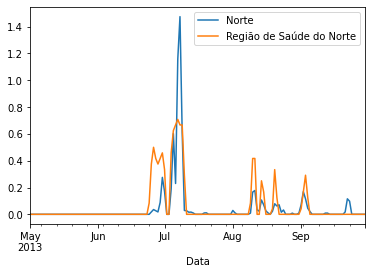

In [70]:
merge_2013[['Norte','Região de Saúde do Norte']].plot()

In [71]:
merge_2013_4.columns

Index(['Norte', 'Centro', 'LVT', 'Alentejo', 'Algarve',
       'Região de Saúde LVT_x', 'Região de Saúde do Alentejo_x',
       'Região de Saúde do Algarve_x', 'Região de Saúde do Centro_x',
       'Região de Saúde do Norte_x', 'Região de Saúde LVT_y',
       'Região de Saúde do Alentejo_y', 'Região de Saúde do Algarve_y',
       'Região de Saúde do Centro_y', 'Região de Saúde do Norte_y',
       'Região de Saúde LVT', 'Região de Saúde do Alentejo',
       'Região de Saúde do Algarve', 'Região de Saúde do Centro',
       'Região de Saúde do Norte'],
      dtype='object')

In [72]:
# Rename all columns with list
cols = ['ICARO - Norte', 'ICARO - Centro', 'ICARO - LVT', 'ICARO - Alentejo', 'ICARO - Algarve',
        'disconfort - Região de Saúde LVT', 'disconfort - Região de Saúde do Alentejo', 'disconfort - Região de Saúde do Algarve', 'disconfort - Região de Saúde do Centro','disconfort - Região de Saúde do Norte',
        'disconfort hours - Região de Saúde LVT', 'disconfort hours - Região de Saúde do Alentejo','disconfort hours - Região de Saúde do Algarve', 'disconfort hours - Região de Saúde do Centro','disconfort hours - Região de Saúde do Norte',
        'Max Temp Região de Saúde LVT', 'Max Temp Região de Saúde do Alentejo','Max Temp Região de Saúde do Algarve', 'Max Temp Região de Saúde do Centro','Max Temp Região de Saúde do Norte'  
        ]
merge_2013_4.columns = cols
merge_2013_4

,ICARO - Norte,ICARO - Centro,ICARO - LVT,ICARO - Alentejo,ICARO - Algarve,disconfort - Região de Saúde LVT,disconfort - Região de Saúde do Alentejo,disconfort - Região de Saúde do Algarve,disconfort - Região de Saúde do Centro,disconfort - Região de Saúde do Norte,disconfort hours - Região de Saúde LVT,disconfort hours - Região de Saúde do Alentejo,disconfort hours - Região de Saúde do Algarve,disconfort hours - Região de Saúde do Centro,disconfort hours - Região de Saúde do Norte,Max Temp Região de Saúde LVT,Max Temp Região de Saúde do Alentejo,Max Temp Região de Saúde do Algarve,Max Temp Região de Saúde do Centro,Max Temp Região de Saúde do Norte
Data,,,,,,,,,,,,,,,,,,,,
2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-05-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2013-09-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.025003,24.366491,21.961515,21.409333,21.636004
2013-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


### 2018

In [73]:
merge_2018=pd.merge(new_icaro_2018.astype(float),disconfort_2018_saude.astype(float), how='inner', left_index=True, right_index=True)

In [74]:
merge_2018_3 = pd.merge(merge_2018.astype(float),discomfort_hours_2018_saude.astype(float),how='left', left_index=True, right_index=True)

In [75]:
merge_2018_4 = pd.merge(merge_2018_3.astype(float),maxtemperatureday_2018_saude.astype(float),how='left', left_index=True, right_index=True)

In [76]:
merge_2018_4

,Norte,Centro,LVT,Alentejo,Algarve,Região de Saúde LVT_x,Região de Saúde do Alentejo_x,Região de Saúde do Algarve_x,Região de Saúde do Centro_x,Região de Saúde do Norte_x,Região de Saúde LVT_y,Região de Saúde do Alentejo_y,Região de Saúde do Algarve_y,Região de Saúde do Centro_y,Região de Saúde do Norte_y,Região de Saúde LVT,Região de Saúde do Alentejo,Região de Saúde do Algarve,Região de Saúde do Centro,Região de Saúde do Norte
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.692003,21.099282,19.672064,19.390022,19.883133
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.325473,20.384622,19.284326,18.674492,19.124845
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.093045,19.946367,19.043135,18.342908,18.733210
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.866727,19.505052,18.802550,18.024695,18.353351
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.642885,19.071423,18.567920,17.728221,17.993154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.876492,23.080978,22.140841,20.219742,19.938214
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.748855,22.997157,22.007713,20.063106,19.811099
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.704250,22.937594,21.964517,20.004785,19.759880
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.516789,22.826801,21.784453,19.785023,19.579016


In [77]:
# Rename all columns with list
cols = ['ICARO - Norte', 'ICARO - Centro', 'ICARO - LVT', 'ICARO - Alentejo', 'ICARO - Algarve',
        'disconfort - Região de Saúde LVT', 'disconfort - Região de Saúde do Alentejo', 'disconfort - Região de Saúde do Algarve', 'disconfort - Região de Saúde do Centro','disconfort - Região de Saúde do Norte',
        'disconfort hours - Região de Saúde LVT', 'disconfort hours - Região de Saúde do Alentejo','disconfort hours - Região de Saúde do Algarve', 'disconfort hours - Região de Saúde do Centro','disconfort hours - Região de Saúde do Norte',
        'Max Temp Região de Saúde LVT', 'Max Temp Região de Saúde do Alentejo','Max Temp Região de Saúde do Algarve', 'Max Temp Região de Saúde do Centro','Max Temp Região de Saúde do Norte'  
        ]
merge_2018_4.columns = cols
merge_2018_4

,ICARO - Norte,ICARO - Centro,ICARO - LVT,ICARO - Alentejo,ICARO - Algarve,disconfort - Região de Saúde LVT,disconfort - Região de Saúde do Alentejo,disconfort - Região de Saúde do Algarve,disconfort - Região de Saúde do Centro,disconfort - Região de Saúde do Norte,disconfort hours - Região de Saúde LVT,disconfort hours - Região de Saúde do Alentejo,disconfort hours - Região de Saúde do Algarve,disconfort hours - Região de Saúde do Centro,disconfort hours - Região de Saúde do Norte,Max Temp Região de Saúde LVT,Max Temp Região de Saúde do Alentejo,Max Temp Região de Saúde do Algarve,Max Temp Região de Saúde do Centro,Max Temp Região de Saúde do Norte
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.692003,21.099282,19.672064,19.390022,19.883133
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.325473,20.384622,19.284326,18.674492,19.124845
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.093045,19.946367,19.043135,18.342908,18.733210
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.866727,19.505052,18.802550,18.024695,18.353351
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.642885,19.071423,18.567920,17.728221,17.993154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.876492,23.080978,22.140841,20.219742,19.938214
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.748855,22.997157,22.007713,20.063106,19.811099
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.704250,22.937594,21.964517,20.004785,19.759880
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.516789,22.826801,21.784453,19.785023,19.579016


In [78]:
merge_2018_4['disconfort hours - Alentejo scale'] = merge_2018_4['disconfort hours - Região de Saúde do Alentejo']/10

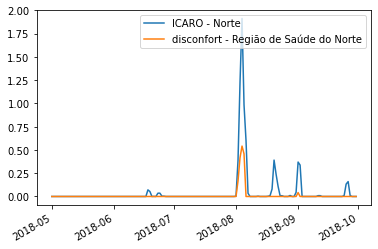

In [79]:
merge_2018_4[['ICARO - Norte','disconfort - Região de Saúde do Norte']].plot()

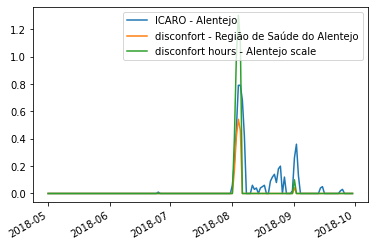

In [80]:
merge_2018_4[['ICARO - Alentejo','disconfort - Região de Saúde do Alentejo','disconfort hours - Alentejo scale']].plot()

## Correlation 

In [76]:
# creation of correlation matrix
corr_merge_2018_4 = merge_2018_4.corr()

In [77]:
corr_merge_2018_4

,ICARO - Norte,ICARO - Centro,ICARO - LVT,ICARO - Alentejo,ICARO - Algarve,disconfort - Região de Saúde LVT,disconfort - Região de Saúde do Alentejo,disconfort - Região de Saúde do Algarve,disconfort - Região de Saúde do Centro,disconfort - Região de Saúde do Norte,...,disconfort hours - Região de Saúde do Alentejo,disconfort hours - Região de Saúde do Algarve,disconfort hours - Região de Saúde do Centro,disconfort hours - Região de Saúde do Norte,Max Temp Região de Saúde LVT,Max Temp Região de Saúde do Alentejo,Max Temp Região de Saúde do Algarve,Max Temp Região de Saúde do Centro,Max Temp Região de Saúde do Norte,disconfort hours - Alentejo scale
ICARO - Norte,1.000000,0.998215,0.729196,0.856018,0.856018,0.921949,0.921949,0.921949,0.921949,0.921949,...,0.921949,0.921949,0.921949,0.921949,0.381559,0.397679,0.342535,0.413467,0.412884,0.921949
ICARO - Centro,0.998215,1.000000,0.750180,0.883146,0.883146,0.920572,0.920572,0.920572,0.920572,0.920572,...,0.920572,0.920572,0.920572,0.920572,0.379526,0.408008,0.353711,0.420237,0.418737,0.920572
ICARO - LVT,0.729196,0.750180,1.000000,0.831211,0.831211,0.628401,0.628401,0.628401,0.628401,0.628401,...,0.628401,0.628401,0.628401,0.628401,0.399319,0.489721,0.440828,0.456028,0.450593,0.628401
ICARO - Alentejo,0.856018,0.883146,0.831211,1.000000,1.000000,0.769871,0.769871,0.769871,0.769871,0.769871,...,0.769871,0.769871,0.769871,0.769871,0.334370,0.467159,0.425481,0.452523,0.444353,0.769871
ICARO - Algarve,0.856018,0.883146,0.831211,1.000000,1.000000,0.769871,0.769871,0.769871,0.769871,0.769871,...,0.769871,0.769871,0.769871,0.769871,0.334370,0.467159,0.425481,0.452523,0.444353,0.769871
disconfort - Região de Saúde LVT,0.921949,0.920572,0.628401,0.769871,0.769871,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.318535,0.308407,0.268239,0.329301,0.329167,1.000000
disconfort - Região de Saúde do Alentejo,0.921949,0.920572,0.628401,0.769871,0.769871,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.318535,0.308407,0.268239,0.329301,0.329167,1.000000
disconfort - Região de Saúde do Algarve,0.921949,0.920572,0.628401,0.769871,0.769871,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.318535,0.308407,0.268239,0.329301,0.329167,1.000000
disconfort - Região de Saúde do Centro,0.921949,0.920572,0.628401,0.769871,0.769871,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.318535,0.308407,0.268239,0.329301,0.329167,1.000000
disconfort - Região de Saúde do Norte,0.921949,0.920572,0.628401,0.769871,0.769871,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.318535,0.308407,0.268239,0.329301,0.329167,1.000000


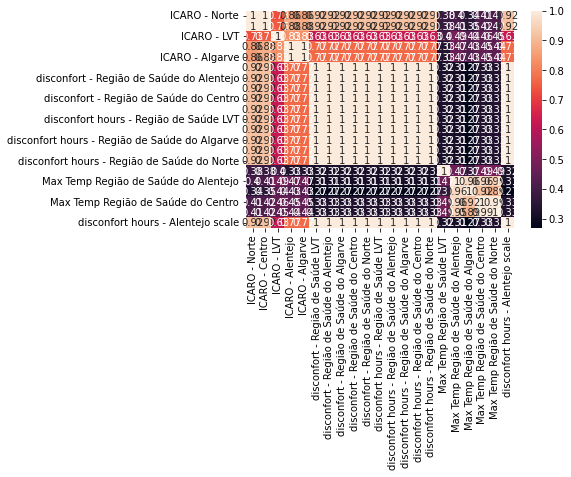

In [78]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corr_merge_2018_4, annot=True)
plt.show()

In [79]:
merge_2018_granger = merge_2013_4[['ICARO - Alentejo','disconfort - Região de Saúde do Alentejo']]

In [80]:
merge_2018_granger.reset_index()

,Data,ICARO - Alentejo,disconfort - Região de Saúde do Alentejo
0,2013-05-01,0.0,0.0
1,2013-05-02,0.0,0.0
2,2013-05-03,0.0,0.0
3,2013-05-04,0.0,0.0
4,2013-05-05,0.0,0.0
...,...,...,...
148,2013-09-26,0.0,0.0
149,2013-09-27,0.0,0.0
150,2013-09-28,0.0,0.0
151,2013-09-29,0.0,0.0


# Distribution municipalities

- average
- worst case
- distribution

In [123]:
maxtemperatureday_2013T = maxtemperatureday_2013.T

In [124]:
maxtemperatureday_2013T['DT_RESID_DSG'] = maxtemperatureday_2013T.index.map(cttdic)
maxtemperatureday_2013T['area saude'] = maxtemperatureday_2013T['DT_RESID_DSG'].map(dic_areas_saude)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-125-9c4981b0ff2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxtemperatureday_2013Talentejo['median'] = maxtemperatureday_2013Talentejo.T.median()


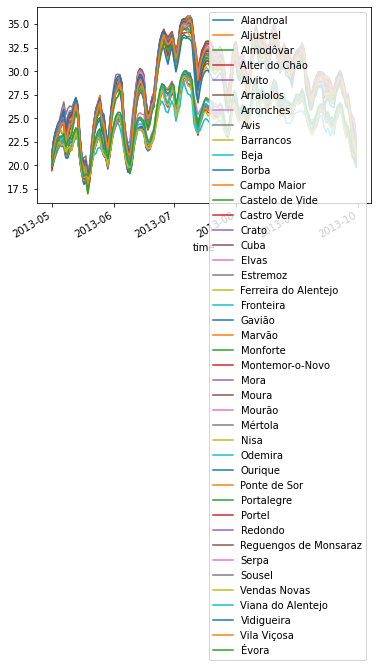

In [125]:
maxtemperatureday_2013Talentejo =  maxtemperatureday_2013T.loc[maxtemperatureday_2013T['area saude'] == 'Região de Saúde do Alentejo']
maxtemperatureday_2013Talentejo.drop(['DT_RESID_DSG','area saude'], axis=1, inplace=True)
maxtemperatureday_2013Talentejo.T.plot()
maxtemperatureday_2013Talentejo['median'] = maxtemperatureday_2013Talentejo.T.median()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


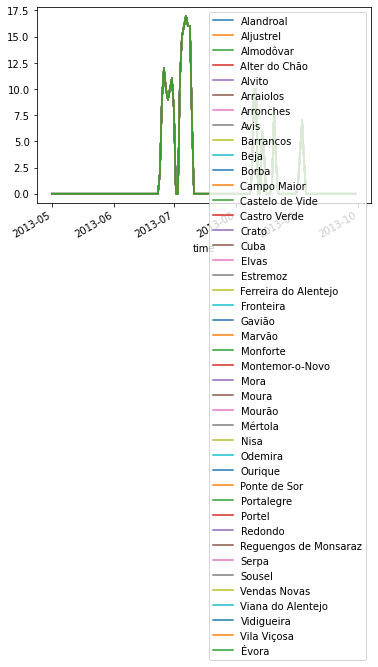

In [126]:
Discomfort_hours_2013_saudeT = Discomfort_hours_2013.T
Discomfort_hours_2013_saudeT
Discomfort_hours_2013_saudeT['DT_RESID_DSG'] = Discomfort_hours_2013_saudeT.index.map(cttdic)
Discomfort_hours_2013_saudeT['area saude'] = Discomfort_hours_2013_saudeT['DT_RESID_DSG'].map(dic_areas_saude)
Discomfort_hours_2013_saudeTalentejo =  Discomfort_hours_2013_saudeT.loc[Discomfort_hours_2013_saudeT['area saude'] == 'Região de Saúde do Alentejo']
Discomfort_hours_2013_saudeTalentejo.drop(['DT_RESID_DSG','area saude'], axis=1, inplace=True)
Discomfort_hours_2013_saudeTalentejo.T.plot()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-127-9c4981b0ff2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxtemperatureday_2013Talentejo['median'] = maxtemperatureday_2013Talentejo.T.median()


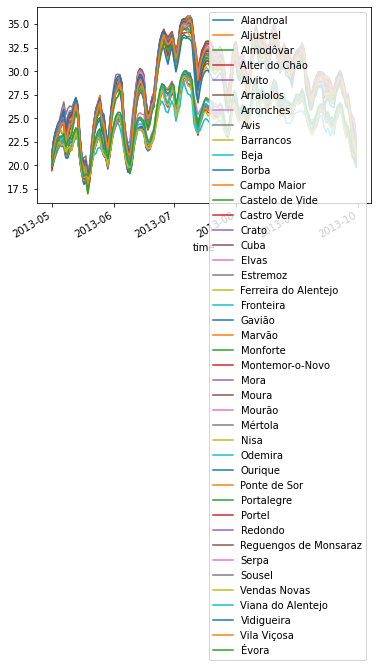

In [127]:
maxtemperatureday_2013Talentejo =  maxtemperatureday_2013T.loc[maxtemperatureday_2013T['area saude'] == 'Região de Saúde do Alentejo']
maxtemperatureday_2013Talentejo.drop(['DT_RESID_DSG','area saude'], axis=1, inplace=True)
maxtemperatureday_2013Talentejo.T.plot()
maxtemperatureday_2013Talentejo['median'] = maxtemperatureday_2013Talentejo.T.median()

In [128]:
testing = maxtemperatureday_2013Talentejo.T
testing.drop(testing.tail(1).index,inplace=True) # drop last n rows
testing

,Alandroal,Aljustrel,Almodôvar,Alter do Chão,Alvito,Arraiolos,Arronches,Avis,Barrancos,Beja,...,Portel,Redondo,Reguengos de Monsaraz,Serpa,Sousel,Vendas Novas,Viana do Alentejo,Vidigueira,Vila Viçosa,Évora
time,,,,,,,,,,,,,,,,,,,,,
2013-05-01,20.879473,20.395115,20.042215,21.25138,20.991693,20.260216,20.908374,20.003083,20.134564,20.834789,...,20.814914,20.028876,20.943259,21.132622,21.191537,19.922248,20.096689,21.000325,20.00472,19.937139
2013-05-02,22.672406,20.810447,21.450662,22.642368,22.635097,22.309059,22.328508,20.768644,21.993407,22.283842,...,22.615648,22.255066,22.863267,22.627469,22.506323,20.759826,21.077439,22.785572,21.87715,21.102306
2013-05-03,23.507769,21.874469,22.307221,23.284516,23.354867,23.122249,22.955171,21.475606,22.854113,23.457971,...,23.493561,23.203377,23.748843,23.678858,23.291644,21.658863,22.039314,23.730273,22.772881,21.966694
2013-05-04,24.060704,22.612969,23.002426,23.997291,24.374411,23.974418,23.606172,22.14547,23.604113,23.98947,...,24.156938,23.871281,24.31061,24.152541,23.841238,22.415148,22.838398,24.382372,23.342688,22.78531
2013-05-05,24.535244,22.781844,23.730232,24.389919,24.681793,24.327849,24.125483,22.440161,24.034832,24.460641,...,24.56682,24.355748,24.728527,24.631009,24.280027,22.410956,22.95819,24.762207,23.837304,23.071436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,27.385507,24.117033,26.534123,27.164839,27.384569,26.974148,27.038301,23.729921,27.004057,27.512064,...,27.3066,27.190046,27.606222,27.133406,27.204378,23.101322,23.965006,27.46569,27.03367,24.111707
2013-09-27,25.847031,22.56694,24.991908,25.694967,25.825077,25.482547,25.680276,22.344527,25.366238,25.9029,...,25.697248,25.653188,25.989557,25.563197,25.7288,21.876994,22.422228,25.875085,25.510464,22.537177
2013-09-28,24.036489,22.046004,24.364528,23.49105,24.191437,23.751447,23.271065,21.305283,24.599543,24.577963,...,24.06054,23.705926,24.423679,24.925341,23.614199,21.407692,21.470254,24.294599,23.378234,21.495486


In [129]:
testing['datetime'] = pd.to_datetime(testing.index)
#testing = testing.reset_index().drop('time',axis=1)
testing = testing.reset_index()
#testing['time'] = pd.to_datetime(testing.time)
testing.head()
testing['time'] = pd.to_datetime(testing['time'], format = '%Y-%m-%d',errors='coerce')

In [130]:
cities_list = testing.columns.tolist()[1:]

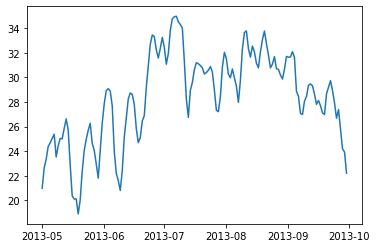

In [131]:
plt.plot(testing['datetime'],testing[cities_list[4]])

In [134]:
#testing = testing.drop('datetime',axis=1)
testing = testing.drop('time',axis=1)
testing

,Alandroal,Aljustrel,Almodôvar,Alter do Chão,Alvito,Arraiolos,Arronches,Avis,Barrancos,Beja,...,Portel,Redondo,Reguengos de Monsaraz,Serpa,Sousel,Vendas Novas,Viana do Alentejo,Vidigueira,Vila Viçosa,Évora
0,20.879473,20.395115,20.042215,21.25138,20.991693,20.260216,20.908374,20.003083,20.134564,20.834789,...,20.814914,20.028876,20.943259,21.132622,21.191537,19.922248,20.096689,21.000325,20.00472,19.937139
1,22.672406,20.810447,21.450662,22.642368,22.635097,22.309059,22.328508,20.768644,21.993407,22.283842,...,22.615648,22.255066,22.863267,22.627469,22.506323,20.759826,21.077439,22.785572,21.87715,21.102306
2,23.507769,21.874469,22.307221,23.284516,23.354867,23.122249,22.955171,21.475606,22.854113,23.457971,...,23.493561,23.203377,23.748843,23.678858,23.291644,21.658863,22.039314,23.730273,22.772881,21.966694
3,24.060704,22.612969,23.002426,23.997291,24.374411,23.974418,23.606172,22.14547,23.604113,23.98947,...,24.156938,23.871281,24.31061,24.152541,23.841238,22.415148,22.838398,24.382372,23.342688,22.78531
4,24.535244,22.781844,23.730232,24.389919,24.681793,24.327849,24.125483,22.440161,24.034832,24.460641,...,24.56682,24.355748,24.728527,24.631009,24.280027,22.410956,22.95819,24.762207,23.837304,23.071436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,27.385507,24.117033,26.534123,27.164839,27.384569,26.974148,27.038301,23.729921,27.004057,27.512064,...,27.3066,27.190046,27.606222,27.133406,27.204378,23.101322,23.965006,27.46569,27.03367,24.111707
149,25.847031,22.56694,24.991908,25.694967,25.825077,25.482547,25.680276,22.344527,25.366238,25.9029,...,25.697248,25.653188,25.989557,25.563197,25.7288,21.876994,22.422228,25.875085,25.510464,22.537177
150,24.036489,22.046004,24.364528,23.49105,24.191437,23.751447,23.271065,21.305283,24.599543,24.577963,...,24.06054,23.705926,24.423679,24.925341,23.614199,21.407692,21.470254,24.294599,23.378234,21.495486
151,23.502192,22.356376,24.179699,22.765089,23.941544,23.031897,22.556673,20.932547,24.032074,24.352891,...,23.544093,23.175251,23.787363,24.557512,22.869448,21.268815,21.494334,23.845801,22.785536,21.37531


In [135]:
# import KMeans
from sklearn.cluster import KMeans
from pandas import DataFrame
# create kmeans object
model = KMeans(n_clusters=2).fit(testing)
pred = model.labels_
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
      dtype=int32)

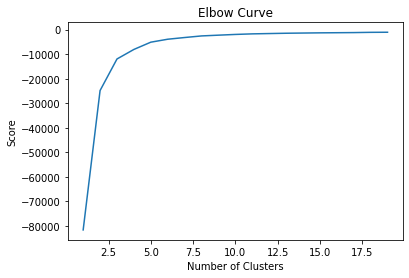

In [136]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(testing).score(testing) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [137]:
testing['Cluster']=pred
testing

,Alandroal,Aljustrel,Almodôvar,Alter do Chão,Alvito,Arraiolos,Arronches,Avis,Barrancos,Beja,...,Redondo,Reguengos de Monsaraz,Serpa,Sousel,Vendas Novas,Viana do Alentejo,Vidigueira,Vila Viçosa,Évora,Cluster
0,20.879473,20.395115,20.042215,21.25138,20.991693,20.260216,20.908374,20.003083,20.134564,20.834789,...,20.028876,20.943259,21.132622,21.191537,19.922248,20.096689,21.000325,20.00472,19.937139,0
1,22.672406,20.810447,21.450662,22.642368,22.635097,22.309059,22.328508,20.768644,21.993407,22.283842,...,22.255066,22.863267,22.627469,22.506323,20.759826,21.077439,22.785572,21.87715,21.102306,0
2,23.507769,21.874469,22.307221,23.284516,23.354867,23.122249,22.955171,21.475606,22.854113,23.457971,...,23.203377,23.748843,23.678858,23.291644,21.658863,22.039314,23.730273,22.772881,21.966694,0
3,24.060704,22.612969,23.002426,23.997291,24.374411,23.974418,23.606172,22.14547,23.604113,23.98947,...,23.871281,24.31061,24.152541,23.841238,22.415148,22.838398,24.382372,23.342688,22.78531,0
4,24.535244,22.781844,23.730232,24.389919,24.681793,24.327849,24.125483,22.440161,24.034832,24.460641,...,24.355748,24.728527,24.631009,24.280027,22.410956,22.95819,24.762207,23.837304,23.071436,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,27.385507,24.117033,26.534123,27.164839,27.384569,26.974148,27.038301,23.729921,27.004057,27.512064,...,27.190046,27.606222,27.133406,27.204378,23.101322,23.965006,27.46569,27.03367,24.111707,0
149,25.847031,22.56694,24.991908,25.694967,25.825077,25.482547,25.680276,22.344527,25.366238,25.9029,...,25.653188,25.989557,25.563197,25.7288,21.876994,22.422228,25.875085,25.510464,22.537177,0
150,24.036489,22.046004,24.364528,23.49105,24.191437,23.751447,23.271065,21.305283,24.599543,24.577963,...,23.705926,24.423679,24.925341,23.614199,21.407692,21.470254,24.294599,23.378234,21.495486,0
151,23.502192,22.356376,24.179699,22.765089,23.941544,23.031897,22.556673,20.932547,24.032074,24.352891,...,23.175251,23.787363,24.557512,22.869448,21.268815,21.494334,23.845801,22.785536,21.37531,0


In [147]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(testing)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_pivot = testing.set_index(cluster_found_sr, append=True )
df_pivot

,,Alandroal,Aljustrel,Almodôvar,Alter do Chão,Alvito,Arraiolos,Arronches,Avis,Barrancos,Beja,...,Redondo,Reguengos de Monsaraz,Serpa,Sousel,Vendas Novas,Viana do Alentejo,Vidigueira,Vila Viçosa,Évora,Cluster
,cluster,,,,,,,,,,,,,,,,,,,,,
0,0,20.879473,20.395115,20.042215,21.25138,20.991693,20.260216,20.908374,20.003083,20.134564,20.834789,...,20.028876,20.943259,21.132622,21.191537,19.922248,20.096689,21.000325,20.00472,19.937139,0
1,0,22.672406,20.810447,21.450662,22.642368,22.635097,22.309059,22.328508,20.768644,21.993407,22.283842,...,22.255066,22.863267,22.627469,22.506323,20.759826,21.077439,22.785572,21.87715,21.102306,0
2,0,23.507769,21.874469,22.307221,23.284516,23.354867,23.122249,22.955171,21.475606,22.854113,23.457971,...,23.203377,23.748843,23.678858,23.291644,21.658863,22.039314,23.730273,22.772881,21.966694,0
3,0,24.060704,22.612969,23.002426,23.997291,24.374411,23.974418,23.606172,22.14547,23.604113,23.98947,...,23.871281,24.31061,24.152541,23.841238,22.415148,22.838398,24.382372,23.342688,22.78531,0
4,0,24.535244,22.781844,23.730232,24.389919,24.681793,24.327849,24.125483,22.440161,24.034832,24.460641,...,24.355748,24.728527,24.631009,24.280027,22.410956,22.95819,24.762207,23.837304,23.071436,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,27.385507,24.117033,26.534123,27.164839,27.384569,26.974148,27.038301,23.729921,27.004057,27.512064,...,27.190046,27.606222,27.133406,27.204378,23.101322,23.965006,27.46569,27.03367,24.111707,0
149,0,25.847031,22.56694,24.991908,25.694967,25.825077,25.482547,25.680276,22.344527,25.366238,25.9029,...,25.653188,25.989557,25.563197,25.7288,21.876994,22.422228,25.875085,25.510464,22.537177,0
150,0,24.036489,22.046004,24.364528,23.49105,24.191437,23.751447,23.271065,21.305283,24.599543,24.577963,...,23.705926,24.423679,24.925341,23.614199,21.407692,21.470254,24.294599,23.378234,21.495486,0


In [148]:
df_pivot = df_pivot.drop('Cluster', axis=1)

In [149]:
df_pivot

,,Alandroal,Aljustrel,Almodôvar,Alter do Chão,Alvito,Arraiolos,Arronches,Avis,Barrancos,Beja,...,Portel,Redondo,Reguengos de Monsaraz,Serpa,Sousel,Vendas Novas,Viana do Alentejo,Vidigueira,Vila Viçosa,Évora
,cluster,,,,,,,,,,,,,,,,,,,,,
0,0,20.879473,20.395115,20.042215,21.25138,20.991693,20.260216,20.908374,20.003083,20.134564,20.834789,...,20.814914,20.028876,20.943259,21.132622,21.191537,19.922248,20.096689,21.000325,20.00472,19.937139
1,0,22.672406,20.810447,21.450662,22.642368,22.635097,22.309059,22.328508,20.768644,21.993407,22.283842,...,22.615648,22.255066,22.863267,22.627469,22.506323,20.759826,21.077439,22.785572,21.87715,21.102306
2,0,23.507769,21.874469,22.307221,23.284516,23.354867,23.122249,22.955171,21.475606,22.854113,23.457971,...,23.493561,23.203377,23.748843,23.678858,23.291644,21.658863,22.039314,23.730273,22.772881,21.966694
3,0,24.060704,22.612969,23.002426,23.997291,24.374411,23.974418,23.606172,22.14547,23.604113,23.98947,...,24.156938,23.871281,24.31061,24.152541,23.841238,22.415148,22.838398,24.382372,23.342688,22.78531
4,0,24.535244,22.781844,23.730232,24.389919,24.681793,24.327849,24.125483,22.440161,24.034832,24.460641,...,24.56682,24.355748,24.728527,24.631009,24.280027,22.410956,22.95819,24.762207,23.837304,23.071436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,27.385507,24.117033,26.534123,27.164839,27.384569,26.974148,27.038301,23.729921,27.004057,27.512064,...,27.3066,27.190046,27.606222,27.133406,27.204378,23.101322,23.965006,27.46569,27.03367,24.111707
149,0,25.847031,22.56694,24.991908,25.694967,25.825077,25.482547,25.680276,22.344527,25.366238,25.9029,...,25.697248,25.653188,25.989557,25.563197,25.7288,21.876994,22.422228,25.875085,25.510464,22.537177
150,0,24.036489,22.046004,24.364528,23.49105,24.191437,23.751447,23.271065,21.305283,24.599543,24.577963,...,24.06054,23.705926,24.423679,24.925341,23.614199,21.407692,21.470254,24.294599,23.378234,21.495486


Text(0.5, 0, 'Day')

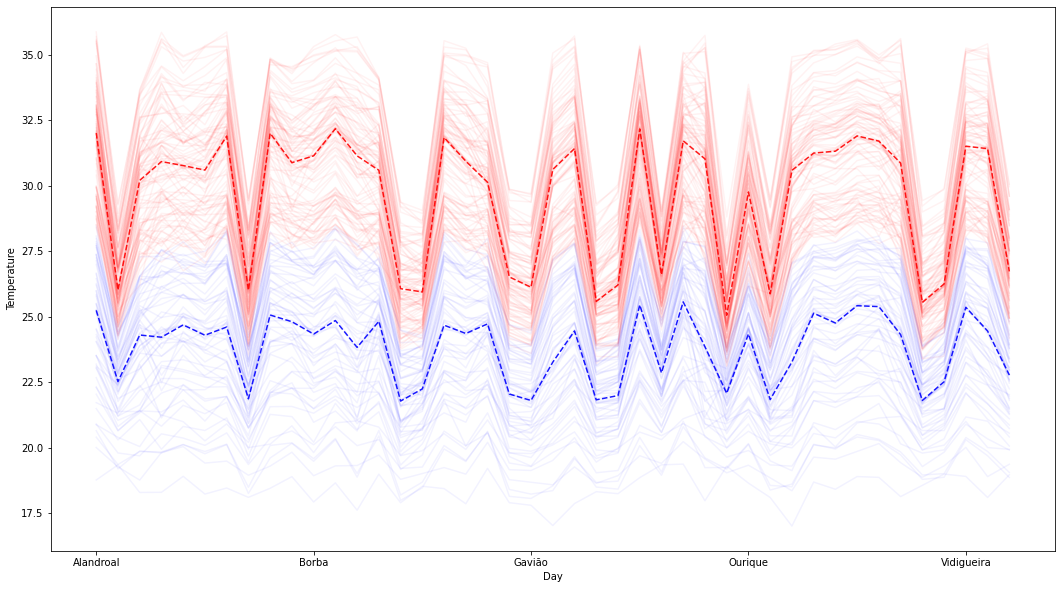

In [150]:
fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())
for cluster, color in zip(cluster_values, color_list):
    df_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.05, color=color, label= f'Cluster {cluster}'
        )
    df_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

#ax.set_xticks(np.arange(1,25))
ax.set_ylabel('Temperature')
ax.set_xlabel('Day')
#ax.legend()

# Icaro, aborve 27, max temp, cluster

# Deaths

In [108]:
dic_distrito =dict({
1: 'Aveiro',
2: 'Beja',
3: 'Braga',
4: 'Bragança',
5: 'Castelo Branco',
6: 'Coimbra',
7: 'Évora',
8: 'Faro',
9: 'Guarda',
10: 'Leiria',
11: 'Lisboa',
12: 'Portalegre',
13: 'Porto',
14: 'Santarém',
15: 'Setúbal',
16: 'Viana do Castelo',
17: 'Vila Real',
18: 'Viseu',
31: 'Ilha da Madeira',
32: 'Ilha de Porto Santo',
41: 'Ilha de Santa Maria',
42: 'Ilha de São Miguel',
43: 'Ilha Terceira',
44: 'Ilha da Graciosa',
45: 'Ilha de São Jorge',
46: 'Ilha do Pico',
47: 'Ilha do Faial',
48: 'Ilha das Flores',
49: 'Ilha do Corvo',
80: 'Ignorado',
90: 'Estrangeiro'})

In [109]:
import pandas as pd
mortalidade_causa_2014  = '/content/drive/Shareddrives/Reliable Project/Data/PED-513988545_210908.zip (Unzipped Files)/bycause_distrito_2014.csv'
mortalidade_causa_2014  = pd.read_csv(mortalidade_causa_2014)
mortalidade_causa_2014['DT_RESID_DSG'] = mortalidade_causa_2014['DT_RESID'].map(dic_distrito)
mortalidade_causa_2014_1	= mortalidade_causa_2014[mortalidade_causa_2014['DT_RESID'] == 1] 
mortalidade_causa_2014_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2014_1['Data_Obito'], infer_datetime_format=True)
mortalidade_causa_2014_1 = mortalidade_causa_2014_1.set_index('Data_Obito')
mortalidade_causa_2014_1.sort_index(inplace=True)
mortalidade_causa_2014_1_I =  mortalidade_causa_2014_1['n.I']

<ipython-input-109-ee1de065067c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortalidade_causa_2014_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2014_1['Data_Obito'], infer_datetime_format=True)


In [110]:
import pandas as pd
mortalidade_causa_2015  = '/content/drive/Shareddrives/Reliable Project/Data/PED-513988545_210908.zip (Unzipped Files)/bycause_distrito_2015.csv'
mortalidade_causa_2015  = pd.read_csv(mortalidade_causa_2015)
mortalidade_causa_2015['DT_RESID_DSG'] = mortalidade_causa_2015['DT_RESID'].map(dic_distrito)
mortalidade_causa_2015_1	= mortalidade_causa_2015[mortalidade_causa_2015['DT_RESID'] == 1] 
mortalidade_causa_2015_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2015_1['Data_Obito'], infer_datetime_format=True)
mortalidade_causa_2015_1 = mortalidade_causa_2015_1.set_index('Data_Obito')
mortalidade_causa_2015_1.sort_index(inplace=True)
mortalidade_causa_2015_1_I =  mortalidade_causa_2015_1['n.I']

<ipython-input-110-d10a6411741e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortalidade_causa_2015_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2015_1['Data_Obito'], infer_datetime_format=True)


In [111]:
import pandas as pd
mortalidade_causa_2016  = '/content/drive/Shareddrives/Reliable Project/Data/PED-513988545_210908.zip (Unzipped Files)/bycause_distrito_2016.csv'
mortalidade_causa_2016  = pd.read_csv(mortalidade_causa_2016)
mortalidade_causa_2016['DT_RESID_DSG'] = mortalidade_causa_2016['DT_RESID'].map(dic_distrito)
mortalidade_causa_2016_1	= mortalidade_causa_2016[mortalidade_causa_2016['DT_RESID'] == 1] 
mortalidade_causa_2016_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2016_1['Data_Obito'], infer_datetime_format=True)
mortalidade_causa_2016_1 = mortalidade_causa_2016_1.set_index('Data_Obito')
mortalidade_causa_2016_1.sort_index(inplace=True)
mortalidade_causa_2016_1_I =  mortalidade_causa_2016_1['n.I']

<ipython-input-111-402cae4ee979>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortalidade_causa_2016_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2016_1['Data_Obito'], infer_datetime_format=True)


In [112]:
import pandas as pd
mortalidade_causa_2017  = '/content/drive/Shareddrives/Reliable Project/Data/PED-513988545_210908.zip (Unzipped Files)/bycause_distrito_2017.csv'
mortalidade_causa_2017  = pd.read_csv(mortalidade_causa_2017)
mortalidade_causa_2017['DT_RESID_DSG'] = mortalidade_causa_2017['DT_RESID'].map(dic_distrito)
mortalidade_causa_2017_1	= mortalidade_causa_2017[mortalidade_causa_2017['DT_RESID'] == 1] 
mortalidade_causa_2017_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2017_1['Data_Obito'], infer_datetime_format=True)
mortalidade_causa_2017_1 = mortalidade_causa_2017_1.set_index('Data_Obito')
mortalidade_causa_2017_1.sort_index(inplace=True)
mortalidade_causa_2017_1_I =  mortalidade_causa_2017_1['n.I']

<ipython-input-112-2a7a2b11c73c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortalidade_causa_2017_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2017_1['Data_Obito'], infer_datetime_format=True)


In [113]:
import pandas as pd
mortalidade_causa_2018  = '/content/drive/Shareddrives/Reliable Project/Data/PED-513988545_210908.zip (Unzipped Files)/bycause_distrito_2018.csv'
mortalidade_causa_2018  = pd.read_csv(mortalidade_causa_2018)
mortalidade_causa_2018['DT_RESID_DSG'] = mortalidade_causa_2018['DT_RESID'].map(dic_distrito)
mortalidade_causa_2018_1	= mortalidade_causa_2018[mortalidade_causa_2018['DT_RESID'] == 1] 
mortalidade_causa_2018_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2018_1['Data_Obito'], infer_datetime_format=True)
mortalidade_causa_2018_1 = mortalidade_causa_2018_1.set_index('Data_Obito')
mortalidade_causa_2018_1.sort_index(inplace=True)
mortalidade_causa_2018_1_I =  mortalidade_causa_2018_1['n.I']

<ipython-input-113-5e6c37fd98e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortalidade_causa_2018_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2018_1['Data_Obito'], infer_datetime_format=True)


In [114]:
import pandas as pd
mortalidade_causa_2019  = '/content/drive/Shareddrives/Reliable Project/Data/PED-513988545_210908.zip (Unzipped Files)/bycause_distrito_2019.csv'
mortalidade_causa_2019  = pd.read_csv(mortalidade_causa_2019)
mortalidade_causa_2019['DT_RESID_DSG'] = mortalidade_causa_2019['DT_RESID'].map(dic_distrito)
mortalidade_causa_2019_1	= mortalidade_causa_2019[mortalidade_causa_2019['DT_RESID'] == 1] 
mortalidade_causa_2019_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2019_1['Data_Obito'], infer_datetime_format=True)
mortalidade_causa_2019_1 = mortalidade_causa_2019_1.set_index('Data_Obito')
mortalidade_causa_2019_1.sort_index(inplace=True)
mortalidade_causa_2019_1_I =  mortalidade_causa_2019_1['n.I']

<ipython-input-114-53e5f3e78e81>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortalidade_causa_2019_1['Data_Obito'] = pd.to_datetime(mortalidade_causa_2019_1['Data_Obito'], infer_datetime_format=True)


In [115]:
mortalidade_causa_2019_1['all'] = mortalidade_causa_2019_1.iloc[:,2:22].astype(np.float64).sum(axis=1)
mortalidade_causa_2018_1['all'] = mortalidade_causa_2018_1.iloc[:,2:22].astype(np.float64).sum(axis=1)
mortalidade_causa_2017_1['all'] = mortalidade_causa_2017_1.iloc[:,2:22].astype(np.float64).sum(axis=1)
mortalidade_causa_2016_1['all'] = mortalidade_causa_2016_1.iloc[:,2:22].astype(np.float64).sum(axis=1)
mortalidade_causa_2015_1['all'] = mortalidade_causa_2015_1.iloc[:,2:22].astype(np.float64).sum(axis=1)

In [116]:
df_circ = pd.concat([mortalidade_causa_2015_1_I, mortalidade_causa_2016_1_I,mortalidade_causa_2017_1_I,mortalidade_causa_2018_1_I,mortalidade_causa_2019_1_I], axis=0)

In [121]:
df_all = pd.concat([mortalidade_causa_2015_1, mortalidade_causa_2016_1,mortalidade_causa_2017_1,mortalidade_causa_2018_1,mortalidade_causa_2019_1], axis=0)

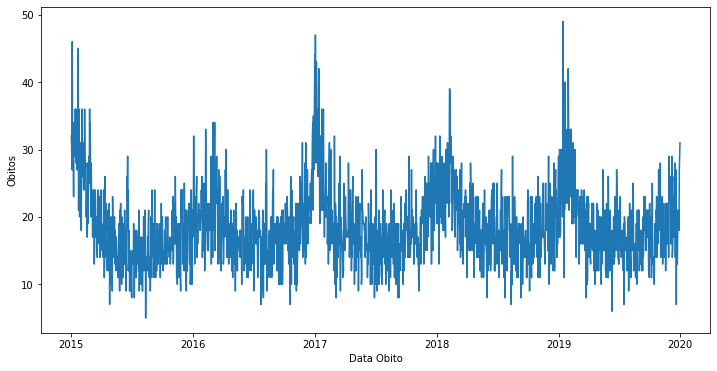

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(df_all['all'])
plt.xlabel('Data Obito')
plt.ylabel('Obitos')
plt.show()

#df_all['all'].plot()

In [120]:
mortalidade_causa_2018_1[['DT_RESID_DSG','all']]

,DT_RESID_DSG,all
Data_Obito,,
2018-01-01,Aveiro,24.0
2018-01-02,Aveiro,19.0
2018-01-03,Aveiro,26.0
2018-01-04,Aveiro,28.0
2018-01-05,Aveiro,23.0
...,...,...
2018-12-27,Aveiro,14.0
2018-12-28,Aveiro,17.0
2018-12-29,Aveiro,16.0
